<a href="https://colab.research.google.com/github/rayanebitout-debug/dataset/blob/main/Mini_Projet_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 1.4 MB/s eta 0:00:00
📥 Téléchargement depuis: https://github.com/rayanebitout-debug/dataset/raw/main/Gainesville.rar
📥 Téléchargement du dataset...
/content/dataset/Ga 100%[===================>]   4.38M  --.-KB/s    in 0.05s   


INFO patool: Extracting /content/dataset/Gainesville.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- /content/dataset/Gainesville.rar


📊 Taille du fichier: 4592278 octets
📦 Décompression du fichier RAR...


INFO patool: ... /content/dataset/Gainesville.rar extracted to `/content/dataset'.


✅ Fichier RAR extrait avec succès
🔍 Recherche des fichiers CSV...
📄 CSV détecté : /content/dataset/Gainesville.csv
🔍 Essai d'encodage: utf-8


/tmp/ipython-input-3850170292.py:119: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, encoding=encoding)


✅ Succès avec l'encodage: utf-8
✅ Données chargées
📊 Shape: (154528, 32)

📋 Aperçu des données:
       id  year zip_code         city state                      climate  \
0  127771  2010    32607  Gainesville    FL  2A Hot - Humid (Houston-TX)   
1  127771  2011    32607  Gainesville    FL  2A Hot - Humid (Houston-TX)   
2  127771  2012    32607  Gainesville    FL  2A Hot - Humid (Houston-TX)   
3  127771  2013    32607  Gainesville    FL  2A Hot - Humid (Houston-TX)   
4  127773  2010    32607  Gainesville    FL  2A Hot - Humid (Houston-TX)   

  building_class          facility_type  floor_area  year_built  ...  \
0    Residential  Residential - Unknown        2632        1972  ...   
1    Residential  Residential - Unknown        2632        1972  ...   
2    Residential  Residential - Unknown        2632        1972  ...   
3    Residential  Residential - Unknown        2632        1972  ...   
4    Residential  Residential - Unknown        2860        1978  ...   

  window_glass

/tmp/ipython-input-3850170292.py:151: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(missing_values, np.nan)


🔢 Conversion des colonnes numériques:
  ✓ electric_eui: 128653/154528 valeurs, min=0.00, max=203.39, moy=23.03
  ✓ fuel_eui: 95859/154528 valeurs, min=0.00, max=128.59, moy=15.52
  ✓ site_eui: 75664/154528 valeurs, min=1.00, max=193.97, moy=36.30
  ✓ source_eui: 75743/154528 valeurs, min=1.27, max=578.54, moy=81.36
  ✓ ghg_emissions_int: 77102/154528 valeurs, min=0.06, max=26.99, moy=3.92
  ✓ year_built: 154528/154528 valeurs, min=1920.00, max=2006.00, moy=1983.43
📉 Colonnes supprimées: 14 (de 32 à 18)
🗑️  Lignes supprimées (toutes NaN): 0
💾 Fichier nettoyé sauvegardé: /content/resultats/Gainesville_clean.csv
🗄️  Base de données créée: /content/resultats/gainesville.db

📊 Génération des visualisations...
  ✓ Graphique Electric EUI sauvegardé


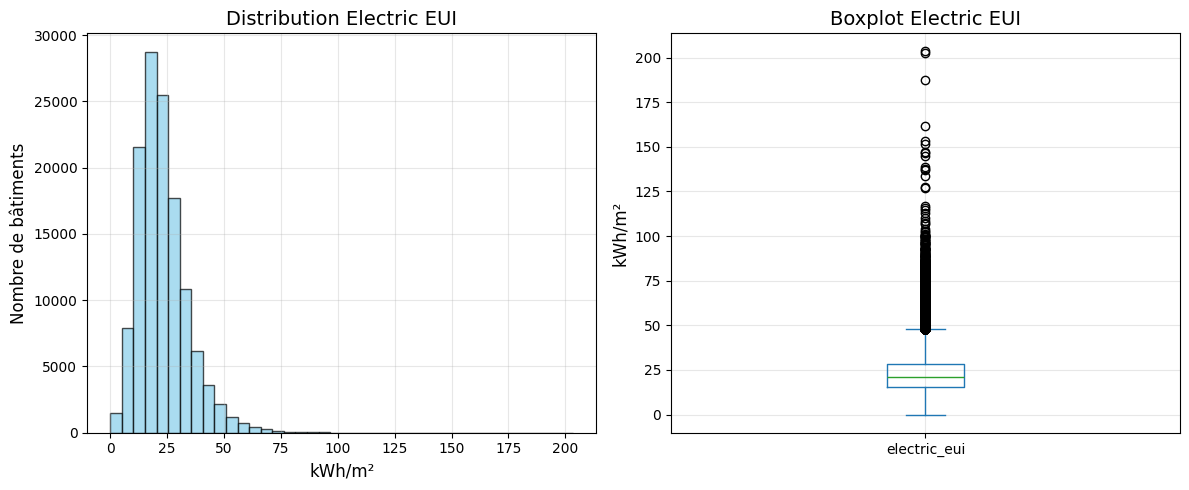

  ✓ Matrice de corrélation sauvegardée


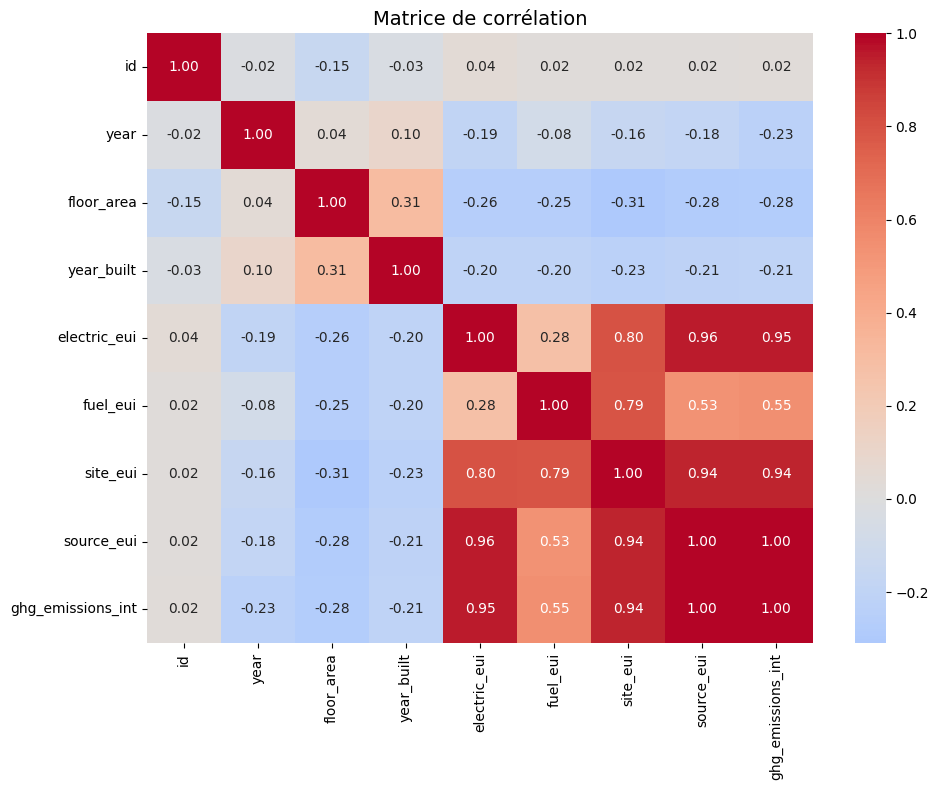


📊 RAPPORT DÉTAILLÉ - ANALYSE ÉNERGÉTIQUE GAINESVILLE

📅 Date d'exécution: 2026-02-05 22:01:51
📁 Fichier source: /content/dataset/Gainesville.csv
📈 Données originales: 154528 lignes × 32 colonnes
🧹 Données nettoyées: 154528 lignes × 18 colonnes

1. RÉSUMÉ STATISTIQUE DES COLONNES NUMÉRIQUES:
--------------------------------------------------

id:
  • Non-null: 154528/154528 (100.0%)
  • Moyenne: 147442.04
  • Médiane: 147293.00
  • Min: 127771.00
  • Max: 168357.00
  • Std: 11462.61

year:
  • Non-null: 154528/154528 (100.0%)
  • Moyenne: 2012.26
  • Médiane: 2012.00
  • Min: 2010.00
  • Max: 2015.00
  • Std: 1.60

floor_area:
  • Non-null: 154528/154528 (100.0%)
  • Moyenne: 1828.39
  • Médiane: 1672.00
  • Min: 500.00
  • Max: 10855.00
  • Std: 743.31

year_built:
  • Non-null: 154528/154528 (100.0%)
  • Moyenne: 1983.43
  • Médiane: 1983.00
  • Min: 1920.00
  • Max: 2006.00
  • Std: 13.47

electric_eui:
  • Non-null: 128653/154528 (83.3%)
  • Moyenne: 23.03
  • Médiane: 21.18
  • Mi

In [ ]:
# ======================================================================================
# GOOGLE COLAB – PIPELINE COMPLET AVEC DATASET RAR
# ======================================================================================

!pip install seaborn -q
!pip install patool -q  # Pour gérer les fichiers .rar

import os
import zipfile
import patoolib  # Pour extraire .rar
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline

# =========================
# CONFIGURATION
# =========================
BASE_DIR = "/content"
DATA_DIR = os.path.join(BASE_DIR, "dataset")
RESULTS_DIR = os.path.join(BASE_DIR, "resultats")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Fichier RAR (car votre fichier est .rar)
RAR_PATH = os.path.join(DATA_DIR, "Gainesville.rar")

# 🔴 LIEN RAW CORRECT POUR GITHUB
DATASET_URL = "https://github.com/rayanebitout-debug/dataset/raw/main/Gainesville.rar"

print(f"📥 Téléchargement depuis: {DATASET_URL}")

# =========================
# TÉLÉCHARGEMENT SÉCURISÉ
# =========================
print("📥 Téléchargement du dataset...")

# Supprimer si existe déjà
if os.path.exists(RAR_PATH):
    os.remove(RAR_PATH)

# Téléchargement
!wget --no-check-certificate -q --show-progress "$DATASET_URL" -O "$RAR_PATH"

# Vérification
if not os.path.exists(RAR_PATH):
    raise RuntimeError("❌ Échec du téléchargement")

file_size = os.path.getsize(RAR_PATH)
print(f"📊 Taille du fichier: {file_size} octets")

if file_size < 1000:
    # Vérifier si c'est une page HTML (erreur 404)
    try:
        with open(RAR_PATH, 'r', encoding='utf-8') as f:
            content = f.read(1000)
            if '<html' in content.lower() or '<!doctype' in content.lower():
                print("❌ Page HTML détectée (lien incorrect)")
                print("Premiers caractères:", content[:200])
                raise RuntimeError("Lien GitHub invalide")
    except:
        pass
    raise RuntimeError("❌ Fichier trop petit - vérifiez le lien")

# =========================
# DÉCOMPRESSION .RAR
# =========================
print("📦 Décompression du fichier RAR...")

try:
    # Extraire avec patool
    patoolib.extract_archive(RAR_PATH, outdir=DATA_DIR)
    print("✅ Fichier RAR extrait avec succès")
except Exception as e:
    print(f"❌ Erreur lors de l'extraction: {e}")
    print("Essayons avec unzip si c'est en fait un zip...")

    # Essayer comme un zip (parfois les fichiers sont mal nommés)
    try:
        with zipfile.ZipFile(RAR_PATH, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
            print("✅ Extraire comme ZIP réussi")
    except:
        raise RuntimeError("Impossible d'extraire le fichier - format non supporté")

# =========================
# CHARGEMENT CSV - CORRIGÉ
# =========================
print("🔍 Recherche des fichiers CSV...")
csv_files = []
for root, dirs, files in os.walk(DATA_DIR):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, f))

if not csv_files:
    # Lister tous les fichiers pour débogage
    print("📁 Fichiers trouvés:")
    for root, dirs, files in os.walk(DATA_DIR):
        for f in files:
            print(f"  - {f}")
    raise FileNotFoundError("❌ Aucun fichier CSV trouvé")

csv_path = csv_files[0]
print(f"📄 CSV détecté : {csv_path}")

# Chargement avec différentes tentatives d'encodage
encodings = ['utf-8', 'latin-1', 'ISO-8859-1', 'cp1252']
df = None

for encoding in encodings:
    try:
        print(f"🔍 Essai d'encodage: {encoding}")
        df = pd.read_csv(csv_path, encoding=encoding)
        print(f"✅ Succès avec l'encodage: {encoding}")
        break
    except UnicodeDecodeError as e:
        print(f"❌ Échec avec {encoding}: {str(e)[:50]}")
    except Exception as e:
        print(f"❌ Autre erreur avec {encoding}: {str(e)[:50]}")

if df is None:
    # Dernière tentative en ignorant les erreurs
    try:
        print("🔄 Dernière tentative avec engine='python'")
        df = pd.read_csv(csv_path, encoding='latin-1', engine='python', on_bad_lines='skip')
    except:
        print("⚠️ Chargement avec pandas par défaut")
        df = pd.read_csv(csv_path)

print("✅ Données chargées")
print(f"📊 Shape: {df.shape}")
print("\n📋 Aperçu des données:")
print(df.head())
print("\n🔍 Info:")
print(df.info())

# =========================
# NETTOYAGE
# =========================
print("\n🧹 Nettoyage des données...")
df_original = df.copy()

# Remplacement des valeurs manquantes
missing_values = ['No Value','Unknown','N/A','NA','','-','--','null','NULL','NaN','nan','None','NONE']
df = df.replace(missing_values, np.nan)

# Liste complète des colonnes potentielles
potential_numeric_cols = [
    'electric_eui','fuel_eui','site_eui','source_eui',
    'ghg_emissions_int','number_of_people',
    'occupant_density','operating_hours',
    'energy_star_rating','leed_score',
    'total_ghg_emissions','electricity_use',
    'natural_gas_use','total_energy_use',
    'building_area','year_built'
]

print("🔢 Conversion des colonnes numériques:")
for col in potential_numeric_cols:
    if col in df.columns:
        # Conversion numérique
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Statistiques
        non_null = df[col].notna().sum()
        total = len(df[col])
        if non_null > 0:
            print(f"  ✓ {col}: {non_null}/{total} valeurs, min={df[col].min():.2f}, max={df[col].max():.2f}, moy={df[col].mean():.2f}")

# Supprimer colonnes avec trop de NaN (>90%)
initial_cols = df.shape[1]
df_cleaned = df.loc[:, df.isna().mean() < 0.9]
final_cols = df_cleaned.shape[1]
df = df_cleaned
print(f"📉 Colonnes supprimées: {initial_cols - final_cols} (de {initial_cols} à {final_cols})")

# Supprimer lignes avec toutes valeurs manquantes
initial_rows = df.shape[0]
df = df.dropna(how='all')
final_rows = df.shape[0]
print(f"🗑️  Lignes supprimées (toutes NaN): {initial_rows - final_rows}")

# Sauvegarde CSV
clean_csv = os.path.join(RESULTS_DIR, "Gainesville_clean.csv")
df.to_csv(clean_csv, index=False, encoding='utf-8')
print(f"💾 Fichier nettoyé sauvegardé: {clean_csv}")

# =========================
# STOCKAGE SQLITE
# =========================
db_path = os.path.join(RESULTS_DIR, "gainesville.db")
conn = sqlite3.connect(db_path)
df.to_sql("gainesville_energy", conn, if_exists="replace", index=False)
conn.close()
print(f"🗄️  Base de données créée: {db_path}")

# =========================
# VISUALISATION
# =========================
print("\n📊 Génération des visualisations...")

# 1. Distribution Electric EUI
if 'electric_eui' in df.columns and df['electric_eui'].notna().sum() > 0:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(df['electric_eui'].dropna(), bins=40, edgecolor='black', alpha=0.7, color='skyblue')
    plt.title("Distribution Electric EUI", fontsize=14)
    plt.xlabel("kWh/m²", fontsize=12)
    plt.ylabel("Nombre de bâtiments", fontsize=12)
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    df['electric_eui'].dropna().plot(kind='box')
    plt.title("Boxplot Electric EUI", fontsize=14)
    plt.ylabel("kWh/m²", fontsize=12)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plot_path = os.path.join(RESULTS_DIR, "electric_eui_distribution.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Graphique Electric EUI sauvegardé")
    plt.show()

# 2. Correlation heatmap si plusieurs colonnes numériques
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] > 2:
    plt.figure(figsize=(10, 8))
    correlation = numeric_df.corr()
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title("Matrice de corrélation", fontsize=14)
    plt.tight_layout()
    corr_path = os.path.join(RESULTS_DIR, "correlation_matrix.png")
    plt.savefig(corr_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Matrice de corrélation sauvegardée")
    plt.show()

# 3. Top 10 des bâtiments par EUI
if 'electric_eui' in df.columns and 'building_name' in df.columns:
    top_buildings = df.dropna(subset=['electric_eui']).nlargest(10, 'electric_eui')[['building_name', 'electric_eui']]
    if len(top_buildings) > 0:
        plt.figure(figsize=(12, 6))
        plt.barh(range(len(top_buildings)), top_buildings['electric_eui'])
        plt.yticks(range(len(top_buildings)), top_buildings['building_name'])
        plt.xlabel('Electric EUI (kWh/m²)')
        plt.title('Top 10 bâtiments par consommation électrique')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        top_path = os.path.join(RESULTS_DIR, "top_buildings_eui.png")
        plt.savefig(top_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Top 10 bâtiments sauvegardé")
        plt.show()

# =========================
# RAPPORT DÉTAILLÉ - AFFICHAGE DIRECT DANS COLAB
# =========================
print("\n" + "="*60)
print("📊 RAPPORT DÉTAILLÉ - ANALYSE ÉNERGÉTIQUE GAINESVILLE")
print("="*60 + "\n")

print(f"📅 Date d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📁 Fichier source: {csv_path}")
print(f"📈 Données originales: {df_original.shape[0]} lignes × {df_original.shape[1]} colonnes")
print(f"🧹 Données nettoyées: {df.shape[0]} lignes × {df.shape[1]} colonnes\n")

print("1. RÉSUMÉ STATISTIQUE DES COLONNES NUMÉRIQUES:")
print("-"*50)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols[:10]:  # Limiter à 10 colonnes pour lisibilité
    print(f"\n{col}:")
    print(f"  • Non-null: {df[col].notna().sum()}/{len(df)} ({df[col].notna().mean()*100:.1f}%)")
    if df[col].notna().sum() > 0:
        print(f"  • Moyenne: {df[col].mean():.2f}")
        print(f"  • Médiane: {df[col].median():.2f}")
        print(f"  • Min: {df[col].min():.2f}")
        print(f"  • Max: {df[col].max():.2f}")
        print(f"  • Std: {df[col].std():.2f}")

if len(numeric_cols) > 10:
    print(f"\n⚠️  ... et {len(numeric_cols) - 10} autres colonnes numériques")

print("\n\n2. COLONNES CATÉGORIELLES (top 5):")
print("-"*50)
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols[:5]:  # Limiter à 5 colonnes
    unique_count = df[col].nunique()
    print(f"\n{col}:")
    print(f"  • Valeurs uniques: {unique_count}")
    if unique_count < 10:  # Afficher les valeurs si peu nombreuses
        print(f"  • Top valeurs:")
        for val, count in df[col].value_counts().head(5).items():
            print(f"    - {val}: {count}")

if len(cat_cols) > 5:
    print(f"\n⚠️  ... et {len(cat_cols) - 5} autres colonnes catégorielles")

print("\n\n3. VALEURS MANQUANTES PAR COLONNE (top 10):")
print("-"*50)
missing_percent = df.isna().mean().sort_values(ascending=False)
for col, percent in missing_percent.head(10).items():
    print(f"{col}: {percent*100:.1f}% manquants")

print("\n\n4. INFORMATIONS GÉNÉRALES:")
print("-"*50)
if 'electric_eui' in df.columns:
    print(f"📊 Consommation électrique moyenne (Electric EUI): {df['electric_eui'].mean():.1f} kWh/m²")
else:
    print("⚠️  Colonne 'electric_eui' non trouvée")

if 'building_name' in df.columns:
    print(f"🏢 Nombre de bâtiments uniques: {df['building_name'].nunique()}")

if 'year_built' in df.columns and df['year_built'].notna().sum() > 0:
    print(f"📅 Plage d'années de construction: {int(df['year_built'].min())} - {int(df['year_built'].max())}")

print("\n" + "="*60)
print("📝 Fin du rapport détaillé")
print("="*60)

# Sauvegarde également dans un fichier (comme avant)
report_path = os.path.join(RESULTS_DIR, "rapport_detaille.txt")
with open(report_path, "w", encoding="utf-8") as f:
    f.write("="*60 + "\n")
    f.write("RAPPORT DÉTAILLÉ - ANALYSE ÉNERGÉTIQUE GAINESVILLE\n")
    f.write("="*60 + "\n\n")
    f.write(f"Date d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Fichier source: {csv_path}\n")
    f.write(f"Données originales: {df_original.shape[0]} lignes × {df_original.shape[1]} colonnes\n")
    f.write(f"Données nettoyées: {df.shape[0]} lignes × {df.shape[1]} colonnes\n\n")

    f.write("1. RÉSUMÉ STATISTIQUE DES COLONNES NUMÉRIQUES:\n")
    f.write("-"*50 + "\n")
    for col in numeric_cols:
        f.write(f"\n{col}:\n")
        f.write(f"  • Non-null: {df[col].notna().sum()}/{len(df)} ({df[col].notna().mean()*100:.1f}%)\n")
        if df[col].notna().sum() > 0:
            f.write(f"  • Moyenne: {df[col].mean():.2f}\n")
            f.write(f"  • Médiane: {df[col].median():.2f}\n")
            f.write(f"  • Min: {df[col].min():.2f}\n")
            f.write(f"  • Max: {df[col].max():.2f}\n")
            f.write(f"  • Std: {df[col].std():.2f}\n")

    f.write("\n\n2. COLONNES CATÉGORIELLES:\n")
    f.write("-"*50 + "\n")
    for col in cat_cols[:10]:
        unique_count = df[col].nunique()
        f.write(f"\n{col}:\n")
        f.write(f"  • Valeurs uniques: {unique_count}\n")
        if unique_count < 20:
             f.write(f"  • Top valeurs: {df[col].value_counts().head().to_dict()}\n")

    f.write("\n\n3. VALEURS MANQUANTES PAR COLONNE:\n")
    f.write("-"*50 + "\n")
    for col, percent in missing_percent.head(20).items():
        f.write(f"{col}: {percent*100:.1f}% manquants\n")

print(f"\n💾 Rapport complet sauvegardé: {report_path}")

# =========================
# SAUVEGARDE SUPPLEMENTAIRE (JSON, EXCEL)
# =========================
# JSON
json_path = os.path.join(RESULTS_DIR, "gainesville_data.json")
df.head(100).to_json(json_path, orient='records', indent=2)  # 100 premières lignes
print(f"📄 JSON exporté: {json_path}")

# Excel
excel_path = os.path.join(RESULTS_DIR, "gainesville_analysis.xlsx")
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name='Données brutes', index=False)
    # Ajouter un résumé
    summary_df = pd.DataFrame({
        'Colonne': df.columns,
        'Type': df.dtypes.astype(str),
        'Non-Null': df.notna().sum().values,
        'Null': df.isna().sum().values,
        '% Null': (df.isna().mean() * 100).round(2).values
    })
    summary_df.to_excel(writer, sheet_name='Résumé', index=False)
print(f"📊 Excel exporté: {excel_path}")

# =========================
# FIN
# =========================
print("\n" + "="*60)
print("🎉🎉🎉 PIPELINE COMPLET TERMINÉ AVEC SUCCÈS! 🎉🎉🎉")
print("="*60)
print("\n📂 FICHIERS PRODUITS DANS /content/resultats/:")
for file in sorted(os.listdir(RESULTS_DIR)):
    file_path = os.path.join(RESULTS_DIR, file)
    size_kb = os.path.getsize(file_path) / 1024
    print(f"  📄 {file} ({size_kb:.1f} KB)")

print(f"\n📁 Pour télécharger les résultats:")
print(f"1. Cliquez sur l'icône 📁 à gauche dans Colab")
print(f"2. Naviguez vers /content/resultats/")
print(f"3. Sélectionnez les fichiers et cliquez sur '...' → 'Download'")

print(f"\n🔗 Accès direct aux fichiers:")
for file in os.listdir(RESULTS_DIR):
    if file.endswith('.png'):
        print(f"  - Graphique: /content/resultats/{file}")
    elif file.endswith('.csv'):
        print(f"  - Données: /content/resultats/{file}")
    elif file.endswith('.txt'):
        print(f"  - Rapport: /content/resultats/{file}")
    elif file.endswith('.json'):
        print(f"  - JSON: /content/resultats/{file}")
    elif file.endswith('.xlsx'):
        print(f"  - Excel: /content/resultats/{file}")
    elif file.endswith('.db'):
        print(f"  - Base SQLite: /content/resultats/{file}")